# 1. Seting up Paths


In [1]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
NEW_MODEL_PATH = WORKSPACE_PATH+'/new-model'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

# 2. Pre-processing of the images

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten,Dropout
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [3]:
TRAIN_PATH=IMAGE_PATH+"/train"
TEST_PATH=IMAGE_PATH+"/test"
VAL_PATH=IMAGE_PATH+"/val"

In [4]:
x_train=[]

for folder in os.listdir(TRAIN_PATH):

    sub_path=TRAIN_PATH+"/"+folder

    for img in os.listdir(sub_path):

        IMAGE_PATH=sub_path+"/"+img

        img_arr=cv2.imread(IMAGE_PATH)

        img_arr=cv2.resize(img_arr,(200,200))

        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(TEST_PATH):

    sub_path=TEST_PATH+"/"+folder

    for img in os.listdir(sub_path):

        IMAGE_PATH=sub_path+"/"+img

        img_arr=cv2.imread(IMAGE_PATH)

        img_arr=cv2.resize(img_arr,(200,200))

        x_test.append(img_arr)

x_val=[]

for folder in os.listdir(VAL_PATH):

    sub_path=VAL_PATH+"/"+folder

    for img in os.listdir(sub_path):

        IMAGE_PATH=sub_path+"/"+img

        img_arr=cv2.imread(IMAGE_PATH)

        img_arr=cv2.resize(img_arr,(200,200))

        x_val.append(img_arr)

In [5]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(TRAIN_PATH,
                                                 target_size = (200, 200),
                                                 batch_size = 16,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(TEST_PATH,
                                            target_size = (200, 200),
                                            batch_size = 16,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(VAL_PATH,
                                            target_size = (200, 200),
                                            batch_size = 16,
                                            class_mode = 'sparse')

Found 10704 images belonging to 2 classes.
Found 3346 images belonging to 2 classes.
Found 2676 images belonging to 2 classes.


In [7]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [8]:
training_set.class_indices

train_y.shape,test_y.shape,val_y.shape

((10704,), (3346,), (2676,))

In [9]:
vgg = VGG19(input_shape = (200, 200, 3), weights='imagenet', include_top=False)

In [10]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [11]:
x = Flatten()(vgg.output)

#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
print(prediction)

KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [12]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [13]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [14]:
from keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model

In [16]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=16,shuffle=True)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

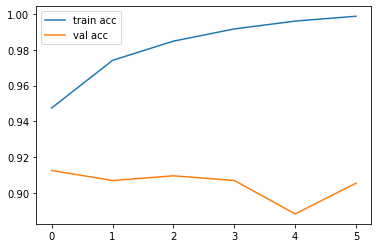

In [27]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-N_B-1.png')

plt.show()

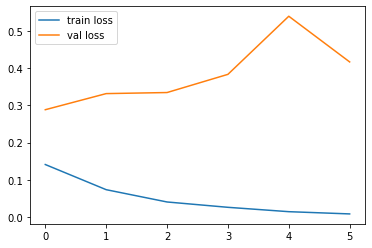

In [29]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-N_B-1.png')
plt.show()

In [19]:
model.evaluate(test_x,test_y,batch_size=32)

105/105 [==============================] - 7s 71ms/step - loss: 0.7182 - accuracy: 0.8709


[0.718235433101654, 0.8708906173706055]

In [20]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [21]:
#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

In [22]:
#get classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1935
           1       0.79      0.94      0.86      1411

    accuracy                           0.87      3346
   macro avg       0.87      0.88      0.87      3346
weighted avg       0.88      0.87      0.87      3346



In [23]:
print(confusion_matrix(y_pred,test_y))
print(prediction)

[[1588  347]
 [  85 1326]]
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [26]:
model.save("vgg-N_B-final.h5")